# Simpsons Classification

**Overview**
*   The model consists of 7 layers
*   Augmentations and learning rate scheduler usage
---
Kaggle submission private score: 0.97550


In [0]:
import numpy as np
import pandas as pd
import torch
import PIL
import pickle
import numpy as np
from skimage import io
import random
from sklearn.metrics import f1_score

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

####Load data

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
#!unzip -q /content/drive/My\ Drive/simpsons/data/dataset.zip -d train
#!unzip -q /content/drive/My\ Drive/simpsons/data/testset.zip -d test

#### Dataset construction

In [0]:
import albumentations as A
from albumentations.pytorch import ToTensor

augmentations_chosen = A.Compose([
                                  A.HorizontalFlip(0.7), 
                                  A.RandomContrast(0.7), 
                                  A.RandomBrightness(0.7),
                                  A.RandomBrightnessContrast(0.7), 
                                  ], p=1)

In [0]:
class SimpsonsDataset(Dataset):
  def __init__(self, files, mode, augmentations = augmentations_chosen):
    super().__init__()
    self.files = files
    self.mode = mode
    self.augmentations = augmentations

    if self.mode not in DATA_MODES:
      print(f'wrong mode: {self.mode}')
      raise NameError

    self.len_ = len(self.files)
    self.label_encoder = LabelEncoder()

    if self.mode != 'test':
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)

      with open('label_encoder.pkl', 'wb') as le_dump:
        pickle.dump(self.label_encoder, le_dump)

  def __len__(self):
    return self.len_

  def load_sample(self, file):
    image = Image.open(file)
    image.load()
    return image

  def __getitem__(self, index):

    transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
    ])

    x = self.load_sample(self.files[index])
    x = self._prepare_sample(x)
    x = np.array(x / 255, dtype='float32')
    x = transform(x)
  
    if self.mode == 'test':
      return x
    else:

      #applying augmentations 
      
      augmented = self.augmentations(image = x.numpy())
      label = self.labels[index]
      label_id = self.label_encoder.transform([label])
      y = label_id.item()
      return x, y

  def _prepare_sample(self, image):
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    return np.array(image)

**Val/train split**

In [0]:
TRAIN_DIR = Path('/content/train/train')
TEST_DIR = Path('/content/test/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.3, \
                                          stratify=train_val_labels)

In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

####Exploring the data

In [0]:
def imshow(img, title=None, plt_ax=plt, default=False):
  img = img.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt_ax.imshow(img)
  if title is not None:
    plt_ax.set_title(title)
  plt_ax.grid(False)


fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10), sharex=True, sharey=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

'\ndef imshow(img, title=None, plt_ax=plt, default=False):\n  img = img.numpy().transpose((1, 2, 0))\n  mean = np.array([0.485, 0.456, 0.406])\n  std = np.array([0.229, 0.224, 0.225])\n  img = std * img + mean\n  img = np.clip(img, 0, 1)\n  plt_ax.imshow(img)\n  if title is not None:\n    plt_ax.set_title(title)\n  plt_ax.grid(False)\n\n\nfig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10), sharex=True, sharey=True)\n\nfor fig_x in ax.flatten():\n    random_characters = int(np.random.uniform(0,1000))\n    im_val, label = val_dataset[random_characters]\n    img_label = " ".join(map(lambda x: x.capitalize(),                val_dataset.label_encoder.inverse_transform([label])[0].split(\'_\')))\n    imshow(im_val.data.cpu(),           title=img_label,plt_ax=fig_x)\n'

####Building the model




In [0]:
class ConvModel(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential( # 224 222 111
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential( # 111 109 54
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3), 
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU()
        )
        self.conv3 = nn.Sequential( # 54 52 26
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential( # 26 24 12
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential( # 12 10 5
            nn.Conv2d(in_channels=96, out_channels=164, kernel_size=3),
            nn.BatchNorm2d(164),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential( # 4100
            nn.Linear(5 * 5 * 164, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential( # 1024
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )        
        self.out = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, 5 * 5 * 164)
        x = self.fc1(x)
        x = self.fc2(x)

        logits = self.out(x)
        return logits

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc
  
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc
  
def train(train_files, val_files, model, epochs, batch_size, scheduler):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      
        for epoch in range(epochs):
            
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer_ft)

            scheduler.step() # changing learning rate

            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [0]:
n_classes = len(np.unique(train_val_labels))
model = ConvModel(n_classes).to(DEVICE)

optimizer_ft = torch.optim.Adam(model.parameters(), lr = 0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

#### Train

In [0]:
history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=32, scheduler=exp_lr_scheduler)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.6109317727587795


epoch:  10%|█         | 1/10 [01:55<17:21, 115.76s/it]


Epoch 001 train_loss: 1.6109     val_loss 1.0997 train_acc 0.5584 val_acc 0.6861
loss 0.9906811145379797


epoch:  20%|██        | 2/10 [03:52<15:27, 115.91s/it]


Epoch 002 train_loss: 0.9907     val_loss 0.8632 train_acc 0.7165 val_acc 0.7540
loss 0.5911282525874971


epoch:  30%|███       | 3/10 [05:48<13:31, 115.96s/it]


Epoch 003 train_loss: 0.5911     val_loss 0.7424 train_acc 0.8323 val_acc 0.7992
loss 0.3687459219633284


epoch:  40%|████      | 4/10 [07:43<11:35, 115.88s/it]


Epoch 004 train_loss: 0.3687     val_loss 0.6261 train_acc 0.8907 val_acc 0.8382
loss 0.2207185193588162


epoch:  50%|█████     | 5/10 [09:41<09:42, 116.46s/it]


Epoch 005 train_loss: 0.2207     val_loss 0.9041 train_acc 0.9331 val_acc 0.8132
loss 0.17909835800167515


epoch:  60%|██████    | 6/10 [11:39<07:47, 116.82s/it]


Epoch 006 train_loss: 0.1791     val_loss 0.8249 train_acc 0.9440 val_acc 0.8245
loss 0.11525238679791484


epoch:  70%|███████   | 7/10 [13:35<05:50, 116.70s/it]


Epoch 007 train_loss: 0.1153     val_loss 0.8360 train_acc 0.9674 val_acc 0.8333
loss 0.0250318330036799


epoch:  80%|████████  | 8/10 [15:31<03:53, 116.52s/it]


Epoch 008 train_loss: 0.0250     val_loss 0.6333 train_acc 0.9932 val_acc 0.8748
loss 0.0031257925004153195


epoch:  90%|█████████ | 9/10 [17:28<01:56, 116.48s/it]


Epoch 009 train_loss: 0.0031     val_loss 0.6452 train_acc 0.9997 val_acc 0.8756
loss 0.0017331542719096695


epoch: 100%|██████████| 10/10 [19:24<00:00, 116.55s/it]


Epoch 010 train_loss: 0.0017     val_loss 0.6626 train_acc 0.9998 val_acc 0.8769


In [0]:
loss, acc, val_loss, val_acc = zip(*history)

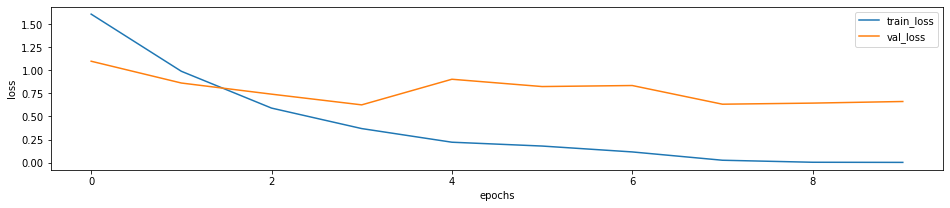

In [0]:
plt.figure(figsize=(16, 3))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [0]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

def Get_F1_Score(model):
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    DEVICE = torch.device("cuda")
    random_characters = int(np.random.uniform(0,1000))
    ex_img, true_label = val_dataset[random_characters]
    probs_im = predict_one_sample(model, ex_img.unsqueeze(0))
    idxs = list(map(int, np.random.uniform(0,1000, 20)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)
    y_pred = np.argmax(probs_ims,-1)

    actual_labels = [val_dataset[id][1] for id in idxs]

    preds_class = [label_encoder.classes_[i] for i in y_pred]
    preds_class_numbers = [val_dataset.label_encoder.transform([name])[0] for name in preds_class] 

    return np.mean(f1_score(actual_labels, preds_class_numbers, average = None))

In [0]:
Get_F1_Score(model)

0.958974358974359


#### Submission



In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [0]:
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [0]:
submit.to_csv('submission.csv', index=False)